In [111]:
import numpy as np 
import matplotlib.pyplot as plt

from astropy.io import fits
import emcee
from scipy.optimize import minimize

import chainconsumer as CC

In [112]:
ddir = '../Spectra/'
fnames = ['98Tau_2023-02-10_04h48m13s_cb.spec.fits','98Tau_2023-02-19_05h21m19s_cb.spec.fits','98Tau_2023-02-26_02h39m39s_cb.spec.fits']
ccfs = [ddir + fname + '.ccf' for fname in fnames]

In [113]:
# Load the CCFs
vels, ccs = [], []

for ccf in ccfs:
    vel, cc = np.loadtxt(ccf, unpack=True)
    vels.append(vel)
    ccs.append(cc)

vels = np.array(vels)
ccs = np.array(ccs)

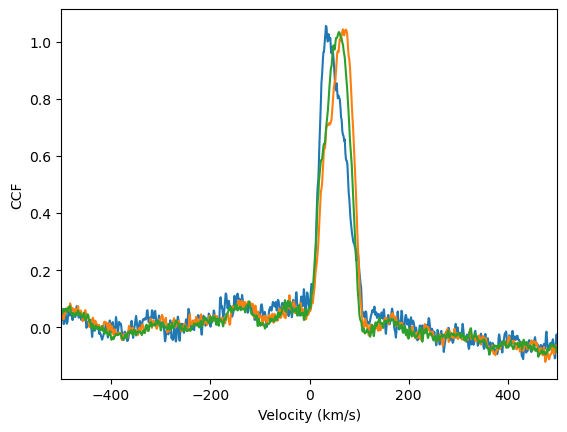

In [114]:
for j in range(3):
    plt.plot(vels[j,:], ccs[j,:])

plt.xlabel('Velocity (km/s)')
plt.ylabel('CCF')
plt.xlim(vels.min(), vels.max())

ccferr = 0.025*np.ones_like(ccs)

In [130]:
# fit a Gaussian to the CCFs
def gaussian(x, a, rv, sigma):
    return a * np.exp(-0.5 * ((x - rv) / sigma)**2)

def log_likelihood(theta, x, y, yerr):
    a, baseline, rv, sigma = theta
    model = gaussian(x, a, rv, sigma) + baseline
    return -0.5 * np.sum((y - model)**2 / yerr**2)

def log_prior(theta):
    a, baseline, rv, sigma = theta
    if 0 < a < 2 and -150 < rv < 150 and 0 < sigma < 100:
        return 0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [131]:
# use the maximum likelihood solution as a starting point
nll = lambda *args: -log_probability(*args)
initial = np.array([1, 0, 50, 10])
soln = minimize(nll, initial, args=(vels[2], ccs[2], ccferr[2]))
a_ml, baseline, mean_ml, sigma_ml = soln.x

pos = soln.x + 1e-4 * np.random.randn(32, 4)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(vels[2], ccs[2], ccferr[2]))

In [132]:
samples = sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:03<00:00, 1376.14it/s]


In [133]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

Mean acceptance fraction: 0.595
Mean amplitude: 1.069 +/- 0.003
Mean RV: 54.512 +/- 0.089
Mean sigma: 25.079 +/- 0.086


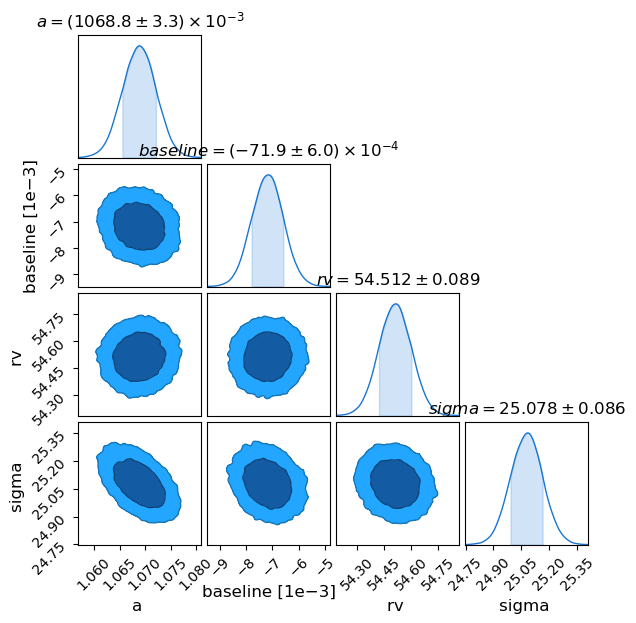

In [134]:
samples.mean(axis=0), samples.std(axis=0)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean amplitude: {0:.3f} +/- {1:.3f}".format(samples[:,0].mean(), samples[:,0].std()))
print("Mean RV: {0:.3f} +/- {1:.3f}".format(samples[:,2].mean(), samples[:,2].std()))
print("Mean sigma: {0:.3f} +/- {1:.3f}".format(samples[:,3].mean(), samples[:,3].std()))

# corner plot with chainconsumer
c = CC.ChainConsumer()
c.add_chain(samples, parameters=["a", "baseline", "rv", "sigma"])
c.configure(statistics='mean')
fig = c.plotter.plot()

(-200.0, 200.0)

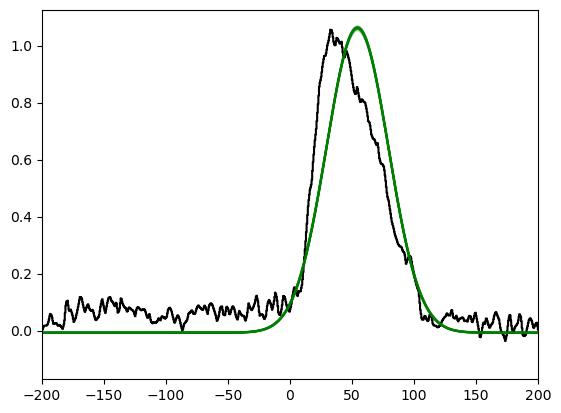

In [136]:
# plot posterior predictive samples over the data

plt.step(vels[0], ccs[0], color='k')

for j in range(50):
    choice = np.random.randint(len(samples))
    a, baseline, rv, sigma = samples[choice]
    plt.plot(vels[0], gaussian(vels[0], a, rv, sigma) + baseline, "g", alpha=0.1)

plt.xlim(-200,200)

## Two Gaussians

Now let's fit a *sum* of 2 Gaussians to the data.

In [151]:
def log_likelihood(theta, x, y, yerr):
    a, rv, sigma, a2, rv2, sigma2, baseline = theta
    model = gaussian(x, a, rv, sigma) + gaussian(x, a2, rv2, sigma2) + baseline
    return -0.5 * np.sum((y - model)**2 / yerr**2)

def log_prior(theta):
    a, rv, sigma, a2, rv2, sigma2, baseline = theta
    if 0 < a < 2 and -20 < rv < 150 and 0 < sigma < 50 and 0 < a2 < 2 and rv < rv2 < 150 and 0 < sigma2 < 50:
        return 0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [152]:
all_samples = []

for k in range(3):
    print('Doing epoch ', k)
    # use the maximum likelihood solution as a starting point
    nll = lambda *args: -log_probability(*args)
    initial = np.array([0.5, 50, 10, 0.5, 50, 10, 0])
    soln = minimize(nll, initial, args=(vels[k], ccs[k], ccferr[k]))
    a_ml, mean_ml, sigma_ml, a2_ml, mean2_ml, sigma2_ml, baseline = soln.x

    pos = soln.x + 1e-4 * np.random.randn(32, 7)

    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(vels[k], ccs[k], ccferr[k]))

    _ = sampler.run_mcmc(pos, 10000, progress=True)
    print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

    samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

    all_samples.append(samples)

/Users/benpope/opt/anaconda3/envs/lk/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Doing epoch  0


  0%|          | 0/10000 [00:00<?, ?it/s]/Users/benpope/opt/anaconda3/envs/lk/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [00:11<00:00, 906.29it/s]


Mean acceptance fraction: 0.482
Doing epoch  1


100%|██████████| 10000/10000 [00:11<00:00, 892.19it/s]


Mean acceptance fraction: 0.467
Doing epoch  2


100%|██████████| 10000/10000 [00:11<00:00, 907.04it/s]

Mean acceptance fraction: 0.477


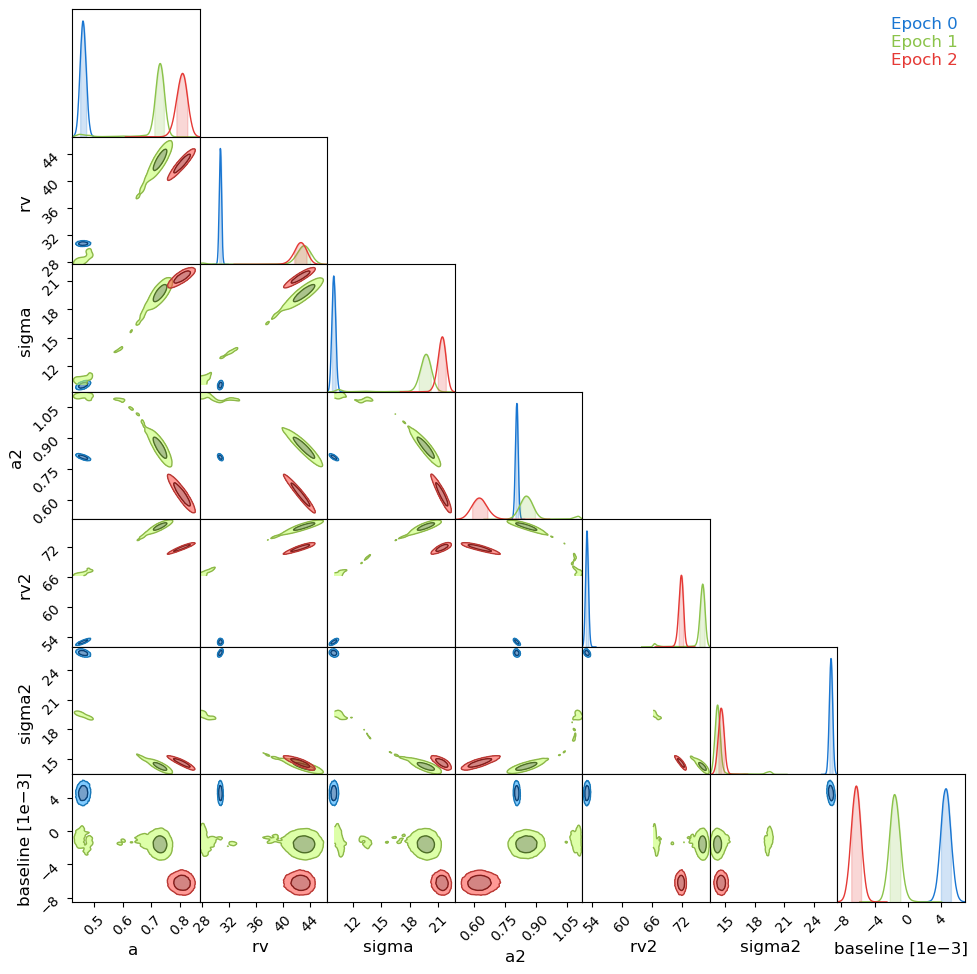

In [156]:
# corner plot with chainconsumer
c = CC.ChainConsumer()
for j in range(3):
    c.add_chain(all_samples[j], parameters=["a", "rv", "sigma", "a2", "rv2", "sigma2", "baseline"], name='Epoch ' + str(j))
c.configure(statistics='mean')
fig = c.plotter.plot()

(-0.2, 1.1)

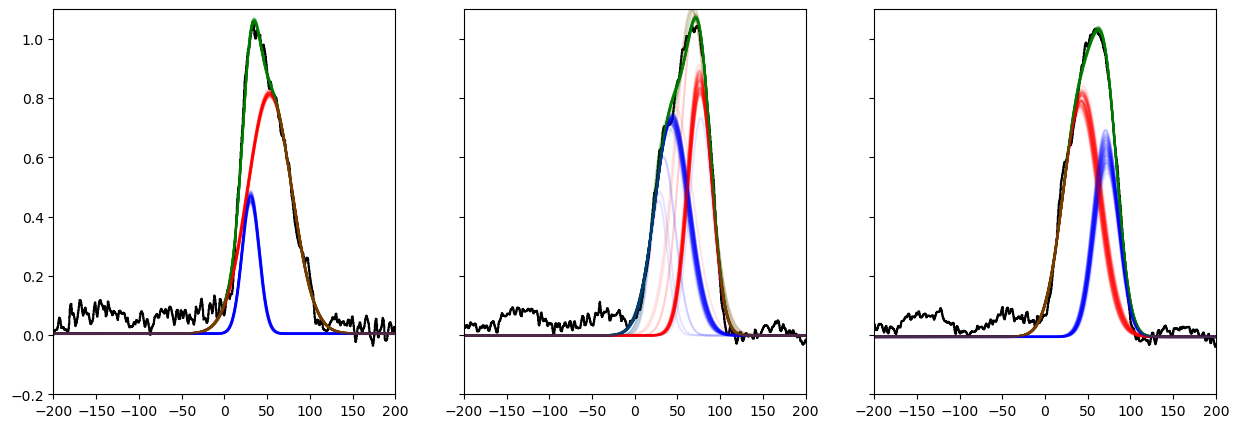

In [172]:
# plot posterior predictive samples over the data

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for j in range(3):
    ax = axes[j]

    samples = all_samples[j]

    ax.step(vels[j], ccs[j], color='k')

    for _ in range(50):

        choice = np.random.randint(len(samples))
        a, rv, sigma, a2, rv2, sigma2, baseline = samples[choice]
        smaller = np.argmin([a, a2])
        if smaller == 0:
            ax.plot(vels[j,:], gaussian(vels[j,:], a, rv, sigma) + baseline, "b", alpha=0.1)
            ax.plot(vels[j,:], gaussian(vels[j,:],a2,rv2,sigma2) + baseline, "r", alpha=0.1)
        else:
            ax.plot(vels[j,:], gaussian(vels[j,:], a, rv, sigma) + baseline, "r", alpha=0.1)
            ax.plot(vels[j,:], gaussian(vels[j,:],a2,rv2,sigma2) + baseline, "b", alpha=0.1)
        ax.plot(vels[j,:], gaussian(vels[j,:], a, rv, sigma) + gaussian(vels[j,:],a2,rv2,sigma2) + baseline, "g", alpha=0.1)


plt.xlim(-200,200)
plt.ylim(-0.2,1.1)

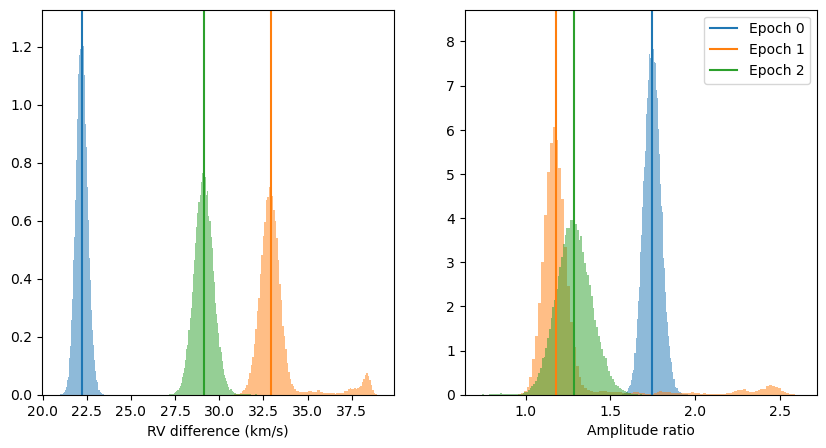

In [178]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


for j in range(3):
    samples = all_samples[j]
    rvdiff = samples[:,4] - samples[:,1]
    ax1.hist(rvdiff,bins=100,alpha=0.5,density=True)
    ax1.axvline(np.median(rvdiff),color='C%d' % j)
    ax1.set_xlabel('RV difference (km/s)')

    amp_ratio = samples[:,3] / samples[:,0]
    if np.median(amp_ratio) < 1:
        amp_ratio = 1 / amp_ratio
    ax2.hist(amp_ratio,bins=100,alpha=0.5,density=True)
    ax2.axvline(np.median(amp_ratio),color='C%d' % j,label='Epoch ' + str(j))
    ax2.set_xlabel('Amplitude ratio')
    ax2.legend()